In [2]:
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [20]:
VERSION_RANDOM_RUN = "v010"
VERSION_SPIU_RUN = "v011"
VERSION_LLM_RUN = "v012"
VERSION_TESTSUITE_RUN = "v013"

# COVERAGE_FOLDER = Path("../data/coverage/v009_four_platforms/")
# PATH_MERGED_JSON_COVERAGE = COVERAGE_FOLDER / "merged_coverage.json"

COVERAGE_FOLDER_RANDOM_RUN = Path(
    f"../data/coverage/{VERSION_RANDOM_RUN}_stats")
COVERAGE_FOLDER_STATS_RANDOM_RUN = Path(
    f"../data/coverage/{VERSION_RANDOM_RUN}_stats")

COVERAGE_FOLDER_SPIU_RUN = Path(
    f"../data/coverage/{VERSION_SPIU_RUN}_stats")
COVERAGE_FOLDER_STATS_SPIU_RUN = Path(
    f"../data/coverage/{VERSION_SPIU_RUN}_stats")

COVERAGE_FOLDER_LLM_RUN = Path(
    f"../data/coverage/{VERSION_LLM_RUN}_four_platforms_parallel")
COVERAGE_FOLDER_TESTSUITE_RUN = Path(
    f"../data/coverage/{VERSION_TESTSUITE_RUN}_four_platforms_parallel")

## Read Data

In [21]:
from multiprocessing import Pool
from tqdm import tqdm


def read_json(file_path: Path) -> Dict[str, Any]:
    with open(file_path, "r") as f:
        return json.load(f)


def read_json_files_in_parallel(
        folder: Path, n_processes: int = 20, filter_suffix: str = "*.json",
        exclusion_pattern: str = None) -> List[
        Dict[str, Any]]:
    """Read all JSON files in a given folder in parallel."""
    json_files = list(folder.rglob(filter_suffix))
    if exclusion_pattern is not None:
        exclusion_regex = re.compile(exclusion_pattern)
        json_files = [f for f in json_files
                      if not exclusion_regex.match(f.name)]

    with Pool(n_processes) as pool:
        json_data = list(
            tqdm(
                pool.imap(read_json, json_files),
                total=len(json_files)))
    return json_data


# Example usage
# json_data_list = read_json_files_in_parallel(COVERAGE_FOLDER_RANDOM)

print(" ==== Reading COVERAGE data.")
# json_coverage_random = read_json_files_in_parallel(
#     COVERAGE_FOLDER_RANDOM_RUN, filter_suffix="*.json",
#     exclusion_pattern=r".*_time\.json$")
# json_coverage_spiu = read_json_files_in_parallel(
#     COVERAGE_FOLDER_SPIU_RUN, filter_suffix="*.json",
#     exclusion_pattern=r".*_time\.json$")
# json_coverage_llm = read_json_files_in_parallel(
#     COVERAGE_FOLDER_LLM_RUN, filter_suffix="*.json",
#     exclusion_pattern=r".*_time\.json$")
json_coverage_test_suite = read_json_files_in_parallel(
    COVERAGE_FOLDER_TESTSUITE_RUN, filter_suffix="*.json",
    exclusion_pattern=r".*_time\.json$")


print(" ==== Reading TIME data.")

# json_time_stats_random = read_json_files_in_parallel(
#     COVERAGE_FOLDER_STATS_RANDOM_RUN, filter_suffix="*_time.json")
# print(f"Read {len(json_time_stats_random)} time stats files for random.")

# json_time_stats_spiu = read_json_files_in_parallel(
#     COVERAGE_FOLDER_STATS_SPIU_RUN, filter_suffix="*_time.json")
# print(f"Read {len(json_time_stats_spiu)} time stats files for SPIU.")

# json_time_llm = read_json_files_in_parallel(
#     COVERAGE_FOLDER_LLM_RUN, filter_suffix="*_time.json")
# print(f"Read {len(json_time_llm)} time stats files for LLM.")

json_time_test_suite = read_json_files_in_parallel(
    COVERAGE_FOLDER_TESTSUITE_RUN, filter_suffix="*_time.json")
print(f"Read {len(json_time_test_suite)} time stats files for test suite.")

print("=== Reading ERROR messages data.")

json_coverage_random_data = [
    d for d in json_coverage_random if "meta" in d]
json_coverage_spiu_data = [
    d for d in json_coverage_spiu if "meta" in d]
json_coverage_llm_data = [
    d for d in json_coverage_llm if "meta" in d]
json_coverage_test_suite_data = [
    d for d in json_coverage_test_suite if "meta" in d]
json_error_random = [
    d for d in json_coverage_random if "exception_message" in d]
json_error_spiu = [
    d for d in json_coverage_spiu if "exception_message" in d]
json_error_llm = [
    d for d in json_coverage_llm if "exception_message" in d]
json_error_test_suite = [
    d for d in json_coverage_test_suite if "exception_message" in d]

print(f"Found {len(json_error_random)} error messages for random.")
print(f"Found {len(json_error_spiu)} error messages for SPIU.")
print(f"Found {len(json_error_llm)} error messages for LLM.")
print(f"Found {len(json_error_test_suite)} error messages for test suite.")

 ==== Reading COVERAGE data.


100%|██████████| 219/219 [00:01<00:00, 120.95it/s]


 ==== Reading TIME data.


100%|██████████| 134/134 [00:00<00:00, 31529.04it/s]


Read 134 time stats files for test suite.
=== Reading ERROR messages data.
Found 5567 error messages for random.
Found 219 error messages for SPIU.
Found 0 error messages for LLM.
Found 85 error messages for test suite.


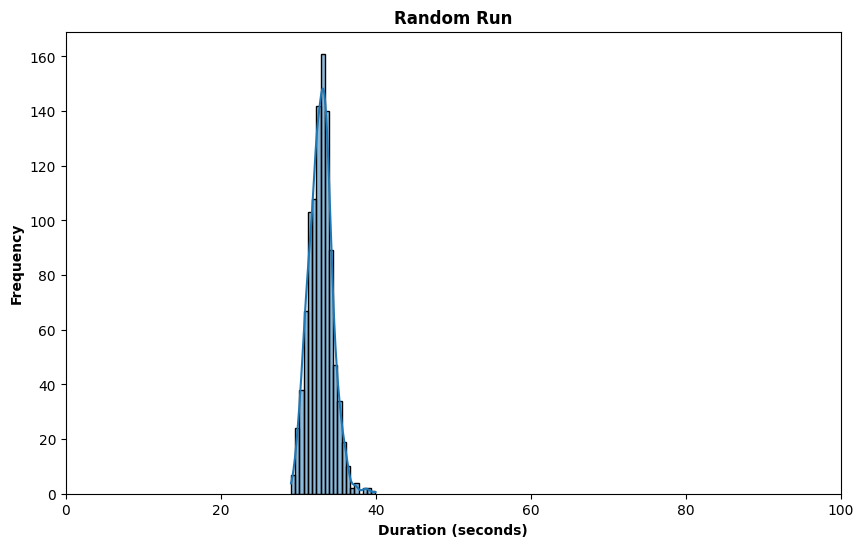

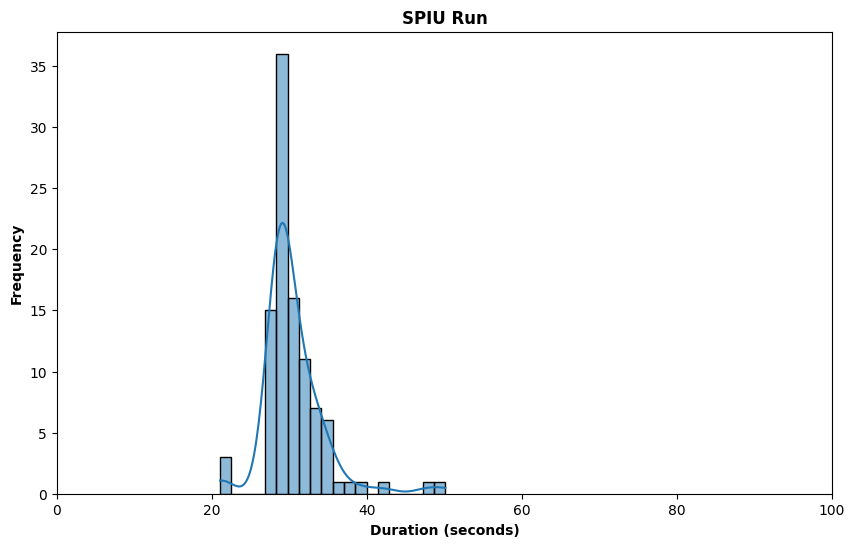

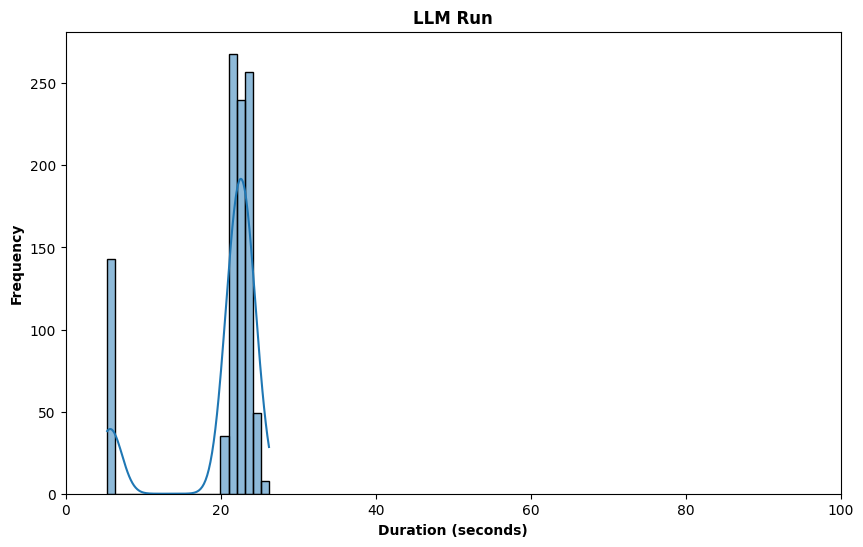

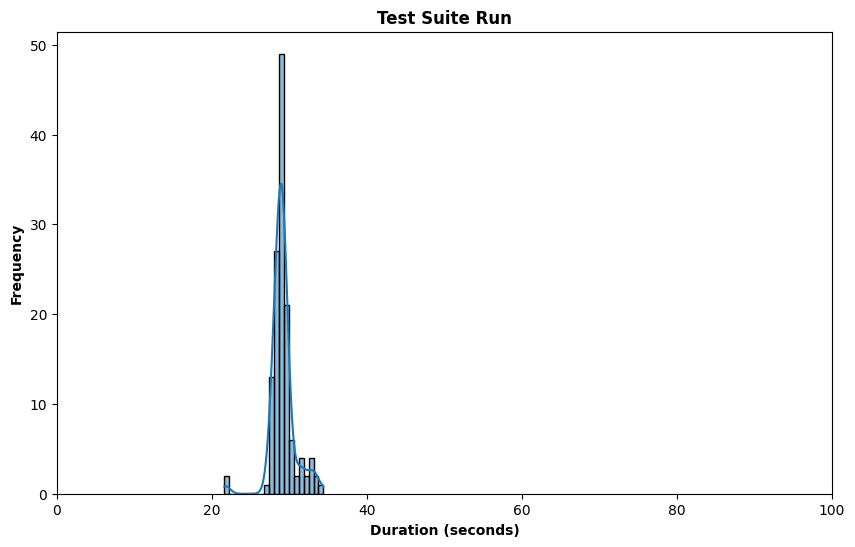

In [22]:
def plot_duration_distribution(
        json_time_stats: List[Dict[str, Any]],
        title: Optional[str] = None
) -> None:
    # Extract the duration field from the json_time_stats records
    durations = [record['duration'] for record in json_time_stats]

    # Convert to a DataFrame
    df_durations = pd.DataFrame(durations, columns=['duration'])

    # Plot the distribution using seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(df_durations['duration'], kde=True, bins=20)
    plt.xlabel('Duration (seconds)', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    if title is not None:
        plt.title(title, fontweight='bold')
    else:
        plt.title('Distribution of Duration', fontweight='bold')
    plt.xlim(0, 100)
    plt.show()


# Example usage
plot_duration_distribution(json_time_stats_random, title="Random Run")
plot_duration_distribution(json_time_stats_spiu, title="SPIU Run")
plot_duration_distribution(json_time_llm, title="LLM Run")
plot_duration_distribution(json_time_test_suite, title="Test Suite Run")

## Helper Function

In [23]:
def merge_coverage_dicts(coverage_dict1: Dict[str, Any],
                         coverage_dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged_coverage = {}

    keys1 = set(coverage_dict1.keys())
    keys2 = set(coverage_dict2.keys())

    only_in_dict1 = keys1 - keys2
    only_in_dict2 = keys2 - keys1

    if only_in_dict1:
        print(f"Keys only in the first coverage dict: {len(only_in_dict1)}")
    if only_in_dict2:
        print(f"Keys only in the second coverage dict: {len(only_in_dict2)}")

    intersection = keys1.intersection(keys2)
    union = keys1.union(keys2)

    for file_path in union:

        if file_path not in intersection:
            if file_path in only_in_dict1:
                file_info = coverage_dict1[file_path]
            else:
                file_info = coverage_dict2[file_path]
            merged_coverage[file_path] = file_info
            continue

        file_info1 = coverage_dict1[file_path]
        file_info2 = coverage_dict2[file_path]
        merged_executed_lines = list(
            set(file_info1['executed_lines']).union(
                set(file_info2['executed_lines'])))
        merged_missing_lines = list(
            set(file_info1['missing_lines']).intersection(
                set(file_info2['missing_lines'])))
        merged_summary = {
            'covered_lines': len(merged_executed_lines),
            'missing_lines': len(merged_missing_lines),
            'percent_covered':
            (len(merged_executed_lines) /
             (len(merged_executed_lines) + len(merged_missing_lines))) * 100}
        merged_coverage[file_path] = {
            'executed_lines': merged_executed_lines,
            'missing_lines': merged_missing_lines,
            'summary': merged_summary
        }
    return merged_coverage


# Test case
test_coverage_info1 = {
    '/path/to/file1.py': {
        'executed_lines': [1, 2, 3],
        'missing_lines': [4, 5],
        'summary': {'covered_lines': 3, 'missing_lines': 2, 'percent_covered': 60.0}
    },
    '/path/to/file2.py': {
        'executed_lines': [1, 2],
        'missing_lines': [3, 4, 5, 6, 7, 8, 9, 10],
        'summary': {'covered_lines': 2, 'missing_lines': 8, 'percent_covered': 20.0}
    }
}

test_coverage_info2 = {
    '/path/to/file1.py': {
        'executed_lines': [2, 3, 4],
        'missing_lines': [1, 5],
        'summary': {'covered_lines': 3, 'missing_lines': 2, 'percent_covered': 60.0}
    },
    '/path/to/file3.py': {
        'executed_lines': [1, 2, 3],
        'missing_lines': [4, 5, 6],
        'summary': {'covered_lines': 3, 'missing_lines': 3, 'percent_covered': 50.0}
    }
}


def test_merge_coverage_dicts():
    merged_coverage = merge_coverage_dicts(
        test_coverage_info1, test_coverage_info2)
    print(merged_coverage)

    assert len(merged_coverage) == 3
    assert '/path/to/file1.py' in merged_coverage
    assert '/path/to/file2.py' in merged_coverage
    assert '/path/to/file3.py' in merged_coverage

    assert merged_coverage['/path/to/file1.py']['summary']['covered_lines'] == 4
    assert merged_coverage['/path/to/file1.py']['summary']['missing_lines'] == 1
    assert merged_coverage['/path/to/file1.py']['summary']['percent_covered'] == 80.0

    assert merged_coverage['/path/to/file2.py']['summary']['covered_lines'] == 2
    assert merged_coverage['/path/to/file2.py']['summary']['missing_lines'] == 8
    assert merged_coverage['/path/to/file2.py']['summary']['percent_covered'] == 20.0


test_merge_coverage_dicts()


def compute_new_summary(files: Dict[str, Any]) -> Dict[str, Any]:
    """Get summary of coverage info"""
    summary_data = {
        "covered_lines": sum(file_info["summary"]["covered_lines"] for file_info in files.values()),
        "missing_lines": sum(file_info["summary"]["missing_lines"] for file_info in files.values())
    }
    summary_data["percent_covered"] = (
        summary_data["covered_lines"] /
        (summary_data["covered_lines"] + summary_data["missing_lines"])) * 100
    return summary_data


def test_compute_new_summary():
    summary_data = compute_new_summary({
        '/path/to/file1.py': {
            'executed_lines': [1, 2, 3],
            'missing_lines': [4, 5],
            'summary': {'covered_lines': 3, 'missing_lines': 2, 'percent_covered': 60.0}
        },
        '/path/to/file2.py': {
            'executed_lines': [1, 2],
            'missing_lines': [3, 4, 5, 6, 7, 8, 9, 10],
            'summary': {'covered_lines': 2, 'missing_lines': 8, 'percent_covered': 20.0}
        }
    })

    assert summary_data["covered_lines"] == 5
    assert summary_data["missing_lines"] == 10
    assert summary_data["percent_covered"] == 33.33333333333333


test_compute_new_summary()

Keys only in the first coverage dict: 1
Keys only in the second coverage dict: 1
{'/path/to/file3.py': {'executed_lines': [1, 2, 3], 'missing_lines': [4, 5, 6], 'summary': {'covered_lines': 3, 'missing_lines': 3, 'percent_covered': 50.0}}, '/path/to/file2.py': {'executed_lines': [1, 2], 'missing_lines': [3, 4, 5, 6, 7, 8, 9, 10], 'summary': {'covered_lines': 2, 'missing_lines': 8, 'percent_covered': 20.0}}, '/path/to/file1.py': {'executed_lines': [1, 2, 3, 4], 'missing_lines': [5], 'summary': {'covered_lines': 4, 'missing_lines': 1, 'percent_covered': 80.0}}}


In [24]:
from datetime import datetime


def process_coverage_data(
        json_data_list: List[Dict[str, Any]],
        top_k: int = 0
) -> pd.DataFrame:

    time_sorted_data = sorted(
        json_data_list, key=lambda x: datetime.fromisoformat(
            x['meta']['timestamp']))

    top_k_data = time_sorted_data[-top_k:]

    cumulative_coverage = {}
    all_records = []

    packages = [
        "/usr/local/lib/python3.10/site-packages/qiskit",
        "/usr/local/lib/python3.10/site-packages/pennylane",
        "/usr/local/lib/python3.10/site-packages/bqskit",
        "/usr/local/lib/python3.10/site-packages/pytket"
    ]

    for i, data in tqdm(enumerate(top_k_data)):
        i_coverage_info = data['files']
        i_timestamp = data['meta']['timestamp']

        cumulative_coverage_files_info = merge_coverage_dicts(
            cumulative_coverage, i_coverage_info)
        i_cum_summary = compute_new_summary(cumulative_coverage_files_info)

        for package in packages:
            package_coverage_files_info = {
                file_path: file_info for file_path,
                file_info in cumulative_coverage_files_info.items()
                if file_path.startswith(package)}
            package_summary = compute_new_summary(package_coverage_files_info)
            package_name = package.split('/')[-1]
            all_records.append({
                "timestamp": i_timestamp,
                "platform": package_name,
                **package_summary,
            })

        cumulative_coverage = cumulative_coverage_files_info
        all_records.append({
            "timestamp": i_timestamp,
            "platform": "four_platforms",
            **i_cum_summary,
        })

    df_coverage = pd.DataFrame(all_records)
    df_coverage['timestamp'] = pd.to_datetime(df_coverage['timestamp'])
    df_coverage = df_coverage.sort_values(by='timestamp')

    return df_coverage


# df_coverage_random = process_coverage_data(
#     json_data_list=json_coverage_random_data, top_k=0)

# df_coverage_spiu = process_coverage_data(
#     json_data_list=json_coverage_spiu_data, top_k=0)

# df_coverage_llm = process_coverage_data(
#     json_data_list=json_coverage_llm_data, top_k=0)

df_coverage_test_suite = process_coverage_data(
    json_data_list=json_coverage_test_suite_data, top_k=0)

0it [00:00, ?it/s]

4it [00:00, 30.88it/s]

Keys only in the second coverage dict: 1645


134it [00:10, 12.64it/s]


In [25]:
# Get the last 5 records of both dataframes
last_5_random = df_coverage_random.tail(5).copy()
last_5_spiu = df_coverage_spiu.tail(5).copy()
last_5_llm = df_coverage_llm.tail(5).copy()
last_5_test_suite = df_coverage_test_suite.tail(5).copy()

# Add a provenance column
last_5_random['generator'] = 'random'
last_5_spiu['generator'] = 'spiu'
last_5_llm['generator'] = 'llm'
last_5_test_suite['generator'] = 'test_suite'

# Merge the dataframes
merged_df = pd.concat(
    [last_5_random, last_5_spiu, last_5_llm, last_5_test_suite])

results = merged_df
pivot_table = merged_df.pivot(
    index='generator', columns='platform', values='percent_covered')
pivot_table = pivot_table[['bqskit', 'pennylane',
                           'pytket', 'qiskit', 'four_platforms']]
pivot_table

# Rename 'four_platforms' to 'combined' in the pivot table
pivot_table.rename(columns={'four_platforms': 'combined'}, inplace=True)

# Convert values to percentages and format them as such
pivot_table = pivot_table.applymap(lambda x: f"{x:.2f}\%")

# Convert the pivot table to LaTeX format
latex_code = pivot_table.to_latex(
    column_format='l' + 'r' * (pivot_table.shape[1]))
print(latex_code)

pivot_table

\begin{tabular}{lrrrrr}
\toprule
platform & bqskit & pennylane & pytket & qiskit & combined \\
generator &  &  &  &  &  \\
\midrule
llm & 0.00\% & 0.00\% & 0.00\% & 37.19\% & 17.89\% \\
random & 23.56\% & 27.34\% & 31.93\% & 32.73\% & 29.68\% \\
spiu & 23.42\% & 27.32\% & 31.87\% & 30.72\% & 28.70\% \\
test_suite & 22.77\% & 27.27\% & 33.27\% & 30.63\% & 28.63\% \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2816379/104099503.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_table = pivot_table.applymap(lambda x: f"{x:.2f}\%")


platform,bqskit,pennylane,pytket,qiskit,combined
generator,,,,,
llm,0.00\%,0.00\%,0.00\%,37.19\%,17.89\%
random,23.56\%,27.34\%,31.93\%,32.73\%,29.68\%
spiu,23.42\%,27.32\%,31.87\%,30.72\%,28.70\%
test_suite,22.77\%,27.27\%,33.27\%,30.63\%,28.63\%


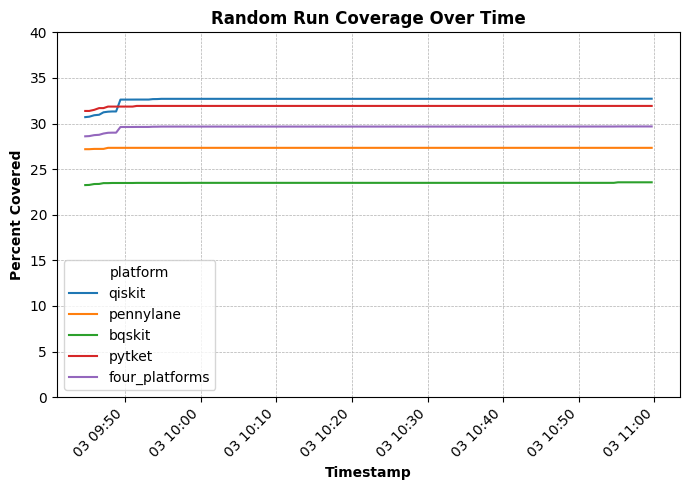

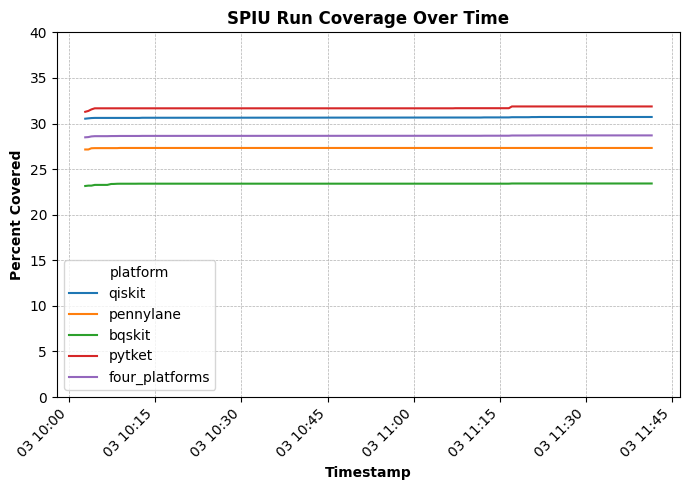

In [9]:

def plot_coverage_percentage_over_time(
        df_coverage: pd.DataFrame, title: Optional[str] = None) -> None:
    # Plot the coverage percentage over time for each platform using seaborn
    plt.figure(figsize=(7, 5))

    # Plot for each platform
    sns.lineplot(x='timestamp', y='percent_covered',
                 hue='platform', data=df_coverage)

    # Add labels and title
    plt.xlabel('Timestamp', fontweight='bold')
    plt.ylabel('Percent Covered', fontweight='bold')
    if title:
        plt.title(title, fontweight='bold')
    else:
        plt.title(
            'Coverage Percentage Over Time for Each Platform',
            fontweight='bold')
    plt.xticks(rotation=45, ha='right')

    plt.ylim(0, 40)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # Show the plot
    plt.tight_layout()
    plt.show()


# Example usage
plot_coverage_percentage_over_time(
    df_coverage_random, title="Random Run Coverage Over Time")
plot_coverage_percentage_over_time(
    df_coverage_spiu, title="SPIU Run Coverage Over Time")

### Miscellanea

In [24]:
with open(PATH_MERGED_JSON_COVERAGE, "r") as f:
    coverage_info = json.load(f)

# coverage_info.keys()
# dict(list(coverage_info["files"].items())[:3])

In [ ]:
def get_coverage_info_single_package(coverage_info, package_name: str) -> Dict[str, Any]:
    """Get coverage info for a single package"""
    all_files = coverage_info["files"]
    package_files = {k: v for k, v in all_files.items()
                     if k.startswith(package_name)}
    fake_coverage_info = {
        "meta": coverage_info["meta"],
        "files": package_files,
        "summary": compute_new_summary(package_files)
    }
    return fake_coverage_info


# Test case
test_coverage_info = {
    '/path/to/file1.py': {
        'executed_lines': [1, 2, 3],
        'missing_lines': [4, 5],
        'summary': {'covered_lines': 3, 'missing_lines': 2, 'percent_covered': 60.0}
    },
    '/path/to/file2.py': {
        'executed_lines': [1, 2],
        'missing_lines': [3, 4, 5, 6, 7, 8, 9, 10],
        'summary': {'covered_lines': 2, 'missing_lines': 8, 'percent_covered': 20.0}
    }
}

# summary_dict = compute_new_summary(test_coverage_info)
# print(summary_dict)

In [ ]:
packages = [
    "/usr/local/lib/python3.10/site-packages/qiskit",
    "/usr/local/lib/python3.10/site-packages/pennylane",
    "/usr/local/lib/python3.10/site-packages/bqskit",
    "/usr/local/lib/python3.10/site-packages/pytket"
]

coverage_summaries = []

for package in packages:
    print(f"Processing package: {package}")
    pkg_coverage_info = get_coverage_info_single_package(
        coverage_info, package_name=package)
    summary = pkg_coverage_info["summary"]
    summary["package"] = package
    coverage_summaries.append(summary)

df_coverage = pd.DataFrame(coverage_summaries)
print(df_coverage)

Processing package: /usr/local/lib/python3.10/site-packages/qiskit
{'covered_lines': 23918, 'missing_lines': 54336}
Processing package: /usr/local/lib/python3.10/site-packages/pennylane
{'covered_lines': 15533, 'missing_lines': 41568}
Processing package: /usr/local/lib/python3.10/site-packages/bqskit
{'covered_lines': 4690, 'missing_lines': 15376}
Processing package: /usr/local/lib/python3.10/site-packages/pytket
{'covered_lines': 2645, 'missing_lines': 5701}
   covered_lines  missing_lines  percent_covered  \
0          23918          54336        30.564572   
1          15533          41568        27.202676   
2           4690          15376        23.372870   
3           2645           5701        31.691828   

                                             package  
0     /usr/local/lib/python3.10/site-packages/qiskit  
1  /usr/local/lib/python3.10/site-packages/pennylane  
2     /usr/local/lib/python3.10/site-packages/bqskit  
3     /usr/local/lib/python3.10/site-packages/pytket  


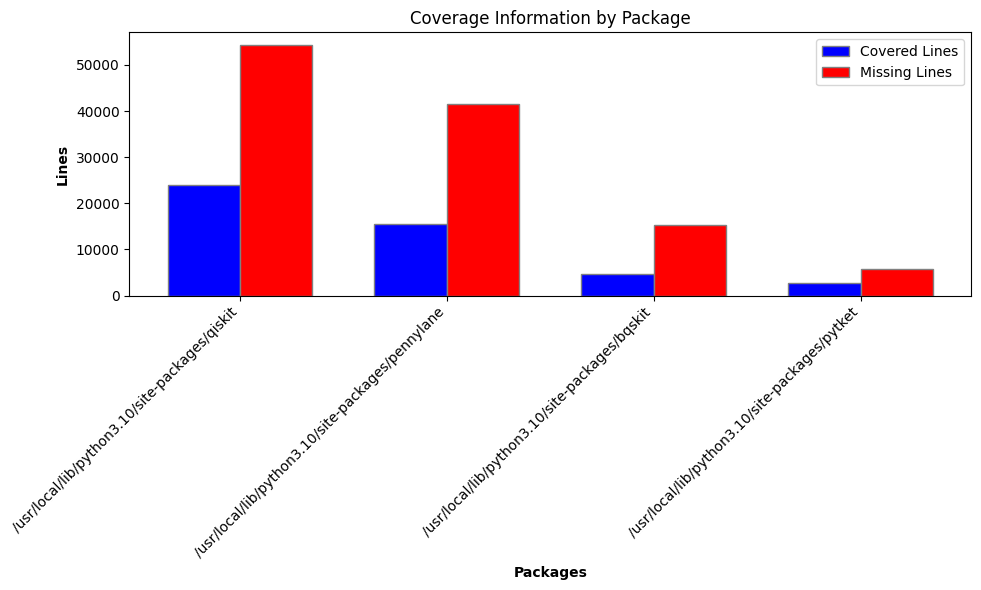

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(df_coverage))
r2 = [x + bar_width for x in r1]

# Create the bar plots
plt.bar(r1, df_coverage['covered_lines'], color='b',
        width=bar_width, edgecolor='grey', label='Covered Lines')
plt.bar(r2, df_coverage['missing_lines'], color='r',
        width=bar_width, edgecolor='grey', label='Missing Lines')

# Add labels
plt.xlabel('Packages', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(df_coverage))],
           df_coverage['package'], rotation=45, ha='right')
plt.ylabel('Lines', fontweight='bold')
plt.title('Coverage Information by Package')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_1750789/1451428692.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='package', y='percent_covered', data=df_coverage, palette='viridis')


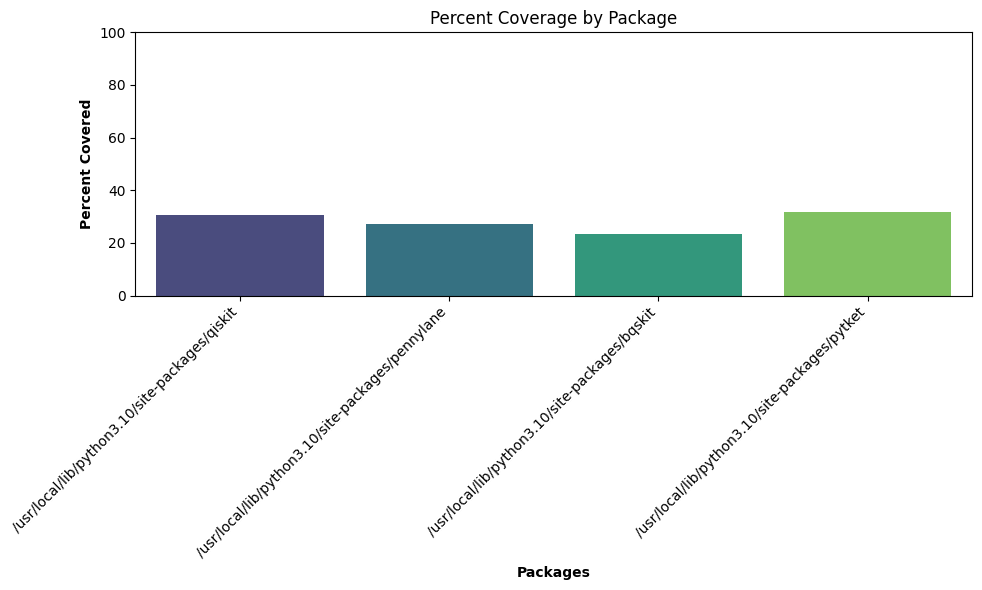

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x='package', y='percent_covered',
            data=df_coverage, palette='viridis')

# Add labels and title
plt.xlabel('Packages', fontweight='bold')
plt.ylabel('Percent Covered', fontweight='bold')
plt.title('Percent Coverage by Package')
plt.xticks(rotation=45, ha='right')
# Set y-axis limits
plt.ylim(0, 100)
# Show the plot
plt.tight_layout()
plt.show()

## RQ1: Compare Coverage

In [10]:
df_errors_random = pd.DataFrame(json_error_random)
df_errors_spiu = pd.DataFrame(json_error_spiu)

df_errors_random.head()

,exception_message,stack_trace,current_file,involved_functions,timestamp
0,Could not import first circuit: <input>:9:1:\n...,"Traceback (most recent call last):\n File ""/w...",qiskit_circuit_5q_10g_1017_06b9c0.py,"[compare_qasm_via_qcec, export_to_qasm_with_bq...",1.733220e+09
1,Could not import first circuit: <input>:5:1:\n...,"Traceback (most recent call last):\n File ""/w...",qiskit_circuit_5q_10g_104_adb1b3.py,"[compare_qasm_via_qcec, export_to_qasm_with_bq...",1.733222e+09
2,"""<input>:12,5: 'cr' is already defined""","Traceback (most recent call last):\n File ""/w...",qiskit_circuit_5q_10g_1074_b3f7d7.py,"[import_from_qasm_with_qiskit, export_to_qasm_...",1.733223e+09
3,"""<input>:5,5: 'cr' is already defined""","Traceback (most recent call last):\n File ""/w...",qiskit_circuit_5q_10g_100_14cc8f.py,"[import_from_qasm_with_qiskit, export_to_qasm_...",1.733219e+09
4,"""<input>:36,5: 'cr' is already defined""","Traceback (most recent call last):\n File ""/w...",qiskit_circuit_5q_10g_1055_dbc850.py,"[import_from_qasm_with_qiskit, export_to_qasm_...",1.733222e+09


## RQ2: Compare Errors Produced

In [11]:
from sentence_transformers import SentenceTransformer
import torch
from transformers import AutoTokenizer, AutoModel
from datasets import Dataset, DatasetDict

EMBEDDING_MODEL = "multi-qa-mpnet-base-cos-v1"
model = SentenceTransformer(EMBEDDING_MODEL)


def embed_exception_messages(model, df):
    df['exception_message_embeddings'] = list(
        model.encode(
            df['exception_message'].tolist(),
            batch_size=32, show_progress_bar=True))
    return df


# Example usage
df_errors_random = embed_exception_messages(model, df_errors_random)
df_errors_spiu = embed_exception_messages(model, df_errors_spiu)

/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

## Uniqueness of Crash Messages

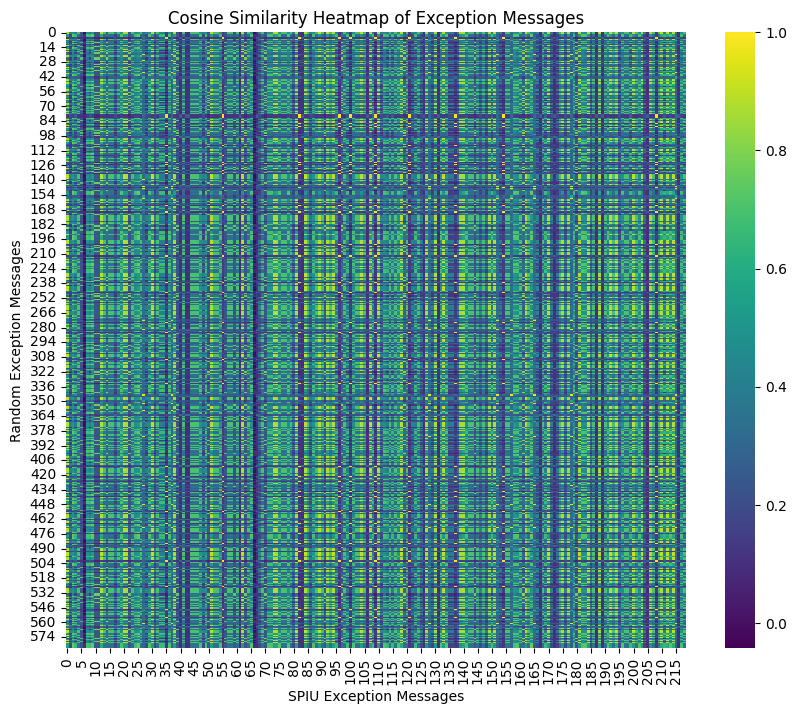

In [12]:
from sklearn.metrics.pairwise import cosine_similarity

# Extract the embeddings
embeddings_random = np.array(
    df_errors_random['exception_message_embeddings'].tolist())
embeddings_spiu = np.array(
    df_errors_spiu['exception_message_embeddings'].tolist())

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings_random, embeddings_spiu)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='viridis', cbar=True)
plt.xlabel('SPIU Exception Messages')
plt.ylabel('Random Exception Messages')
plt.title('Cosine Similarity Heatmap of Exception Messages')
plt.show()

In [ ]:
TOP_K_UNIQUE = 20

row_max_values = similarity_matrix.max(axis=1)
col_max_values = similarity_matrix.max(axis=0)

# Get the indices of the top_k rows with the lowest maximum similarity values
top_k_row_indices = row_max_values.argsort()[:TOP_K_UNIQUE]

print("=" * 80)
print(f"Top {TOP_K_UNIQUE} Random exception messages with the lowest maximum similarity:")
for idx in top_k_row_indices:
    print(f"Max similarity value: {row_max_values[idx]}")
    print(df_errors_random.iloc[idx]['exception_message'])
    print()

# Get the indices of the top_k columns with the lowest maximum similarity values
top_k_col_indices = col_max_values.argsort()[:TOP_K_UNIQUE]

print("=" * 80)
print(f"Top {TOP_K_UNIQUE} SPIU exception messages with the lowest maximum similarity:")
for idx in top_k_col_indices:
    print(f"Max similarity value: {col_max_values[idx]}")
    print(df_errors_spiu.iloc[idx]['exception_message'])
    print()

Top 20 Random exception messages with the lowest maximum similarity:
Max similarity value: 0.3616364300251007
'DaggerGate' object has no attribute '_qasm_name'

Max similarity value: 0.3616364300251007
'DaggerGate' object has no attribute '_qasm_name'

Max similarity value: 0.3616364300251007
'DaggerGate' object has no attribute '_qasm_name'

Max similarity value: 0.3616364300251007
'DaggerGate' object has no attribute '_qasm_name'

Max similarity value: 0.3616364300251007
'DaggerGate' object has no attribute '_qasm_name'

Max similarity value: 0.3616364300251007
'DaggerGate' object has no attribute '_qasm_name'

Max similarity value: 0.3616364300251007
'DaggerGate' object has no attribute '_qasm_name'

Max similarity value: 0.36163651943206787
'DaggerGate' object has no attribute '_qasm_name'

Max similarity value: 0.36163651943206787
'DaggerGate' object has no attribute '_qasm_name'

Max similarity value: 0.36163651943206787
'DaggerGate' object has no attribute '_qasm_name'

Max simi

### Percentage of Each Oracle Crash

Random warning with equivalence checker:
226/585 (38.63%)
SPIU warning with equivalence checker:
121/219 (55.25%)


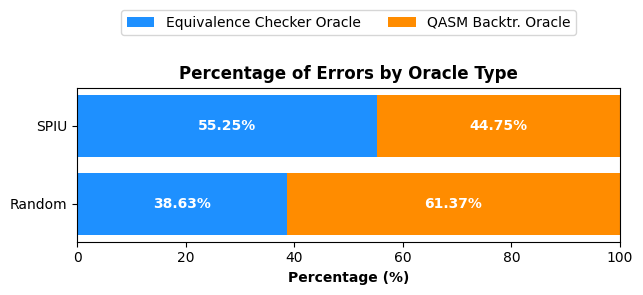

In [ ]:
def count_errors_with_function(
        df, function_name, exclude_error_message: str = None):
    total = len(df)
    df = df.copy()
    if exclude_error_message is not None:
        df = df[~df['exception_message'].str.contains(exclude_error_message)]
    count = df['involved_functions'].apply(lambda x: function_name in x).sum()
    percentage = (count / total) * 100
    return count, total, percentage


# Count errors for random errors dataframe
count_random, total_random, percentage_random = count_errors_with_function(
    df_errors_random,
    function_name='compare_qasm_via_qcec')
print(f"Random warning with equivalence checker:")
print(f"{count_random}/{total_random} ({percentage_random:.2f}%)")

# Count errors for spiu errors dataframe
count_spiu, total_spiu, percentage_spiu = count_errors_with_function(
    df_errors_spiu,
    function_name='compare_qasm_via_qcec')
print(f"SPIU warning with equivalence checker:")
print(f"{count_spiu}/{total_spiu} ({percentage_spiu:.2f}%)")

# Create a horizontal bar plot for the percentages
labels = ['Random', 'SPIU']
percentages_eq_checker = [percentage_random, percentage_spiu]
percentages_qasm_backtr = [100 - percentage_random, 100 - percentage_spiu]

fig, ax = plt.subplots(figsize=(7, 2))

# Plot the bars
ax.barh(labels, percentages_eq_checker, color='dodgerblue',
        label='Equivalence Checker Oracle')
ax.barh(labels, percentages_qasm_backtr, left=percentages_eq_checker,
        color='darkorange', label='QASM Backtr. Oracle')

# Add labels and title
ax.set_xlabel('Percentage (%)', fontweight='bold')
ax.set_title('Percentage of Errors by Oracle Type', fontweight='bold')

# Add the percentage values on the bars
for i, (v1, v2) in enumerate(
        zip(percentages_eq_checker, percentages_qasm_backtr)):
    ax.text(v1 / 2, i, f"{v1:.2f}%", ha='center',
            va='center', fontweight='bold', color='white')
    ax.text(v1 + v2 / 2, i, f"{v2:.2f}%", ha='center',
            va='center', fontweight='bold', color='white')

plt.xlim(0, 100)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.55), ncol=2)
plt.show()

### Overlapping Covered Lines

In [40]:
MERGE_COVERAGE_PATH_RANDOM = COVERAGE_FOLDER_RANDOM_RUN / "merged_coverage.json"
MERGE_COVERAGE_PATH_SPIU = COVERAGE_FOLDER_SPIU_RUN / "merged_coverage.json"

In [ ]:
# read the two merged coverage files
with open(MERGE_COVERAGE_PATH_RANDOM, "r") as f:
    merged_coverage_random = json.load(f)

with open(MERGE_COVERAGE_PATH_SPIU, "r") as f:
    merged_coverage_spiu = json.load(f)

In [ ]:
# merged_coverage_random["files"]['/usr/local/lib/python3.10/site-packages/qiskit/__init__.py']  # this contains a list of integer with the covered lines of this file

covered_lines_random = [
    f"{file_path}:{line}" for file_path,
    file_info in merged_coverage_random["files"].items()
    for line in file_info["executed_lines"]]

covered_lines_spiu = [
    f"{file_path}:{line}" for file_path,
    file_info in merged_coverage_spiu["files"].items()
    for line in file_info["executed_lines"]]

print(f"Total covered lines in random run: {len(covered_lines_random)}")
print(f"Total covered lines in SPIU run: {len(covered_lines_spiu)}")

Total covered lines in random run: 48607
Total covered lines in SPIU run: 46995


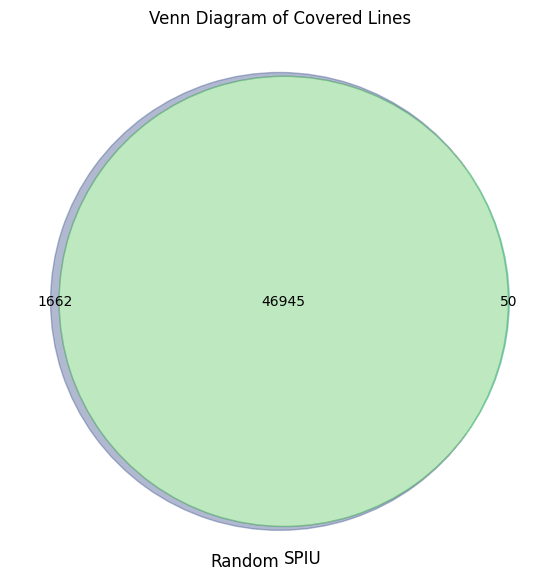

In [53]:
from matplotlib_venn import venn2
import seaborn as sns

# Compute the sets
set_random = set(covered_lines_random)
set_spiu = set(covered_lines_spiu)

# Compute the intersection and differences
only_random = set_random - set_spiu
only_spiu = set_spiu - set_random
intersection = set_random & set_spiu

# Create the Venn diagram
plt.figure(figsize=(10, 7))
venn = venn2([set_random, set_spiu], ('Random', 'SPIU'))

# Set colors using seaborn palette
colors = sns.color_palette("viridis", 3)
venn.get_label_by_id('10').set_text(len(only_random))
venn.get_label_by_id('01').set_text(len(only_spiu))
venn.get_label_by_id('11').set_text(len(intersection))

# Set colors
venn.get_patch_by_id('10').set_color(colors[0])
venn.get_patch_by_id('01').set_color(colors[1])
venn.get_patch_by_id('11').set_color(colors[2])

# Add title
plt.title('Venn Diagram of Covered Lines')
plt.show()